In [1]:
!pip install -q flwr[simulation] deepbrain 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 25.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.6/677.6 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.0/540.0 kB 26.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.8 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you

In [2]:
# Standard libraries
import os
import warnings
import math
import random
from pathlib import Path
from collections import Counter, OrderedDict
from typing import List, Tuple, Dict, Optional, Union, Callable
from enum import IntEnum

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from tqdm import tqdm
from ipywidgets import interact

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset

# Torchvision
import torchvision.transforms as transforms

# Flower
import flwr
from flwr.client import Client, ClientApp
from flwr.common import (
    Code, EvaluateIns, EvaluateRes, FitIns, FitRes, GetParametersIns, GetParametersRes,
    Status, Parameters, Scalar, NDArray, NDArrays, ndarrays_to_parameters, parameters_to_ndarrays, Context
)
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import Strategy
from flwr.simulation import run_simulation

# HuggingFace Datasets
from datasets.utils.logging import disable_progress_bar, set_verbosity_error

2025-06-02 10:30:14.711260: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748860214.967226      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748860215.079387      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Thiết lập thiết bị
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()
set_verbosity_error()
warnings.filterwarnings("ignore")

# Định nghĩa drop out
class CustomCode(IntEnum):
    DROPPED_OUT = 100

Training on cuda
Flower 1.18.0 / PyTorch 2.5.1+cu124


In [4]:
NUM_CLIENTS = 10
NUM_ROUNDS = 30
DROPOUT = 0.5
BATCHSIZE = 128
OVERLAP = 0.6
LR = 0.1
MU = 0.1
epochs_round = 1

In [5]:
data_dir = '/kaggle/input/mri-dataset/datasetzip/not_skull_stripped'
label_path = list(Path(data_dir).glob("*.xlsx"))
label_ls = pd.read_excel(label_path[0])
label_ls

,subject_age,subject_dx,subject_sex,subject_id,dataset_name
0,55.4,pathology,m,sub-BrainAge000000,ABIDE/Caltech
1,22.9,pathology,m,sub-BrainAge000001,ABIDE/Caltech
2,39.2,pathology,m,sub-BrainAge000002,ABIDE/Caltech
3,22.8,pathology,m,sub-BrainAge000003,ABIDE/Caltech
4,34.6,pathology,f,sub-BrainAge000004,ABIDE/Caltech
...,...,...,...,...,...
23209,66,control,f,sub-BrainAge023209,RocklandSample
23210,69,control,m,sub-BrainAge023210,RocklandSample
23211,23,control,m,sub-BrainAge023211,RocklandSample
23212,54,control,f,sub-BrainAge023212,RocklandSample


In [6]:
label_ls = label_ls[(label_ls['subject_dx'] == 'control') & ((label_ls['subject_sex'] == 'm') | (label_ls['subject_sex'] == 'f'))]
len(label_ls)

8764

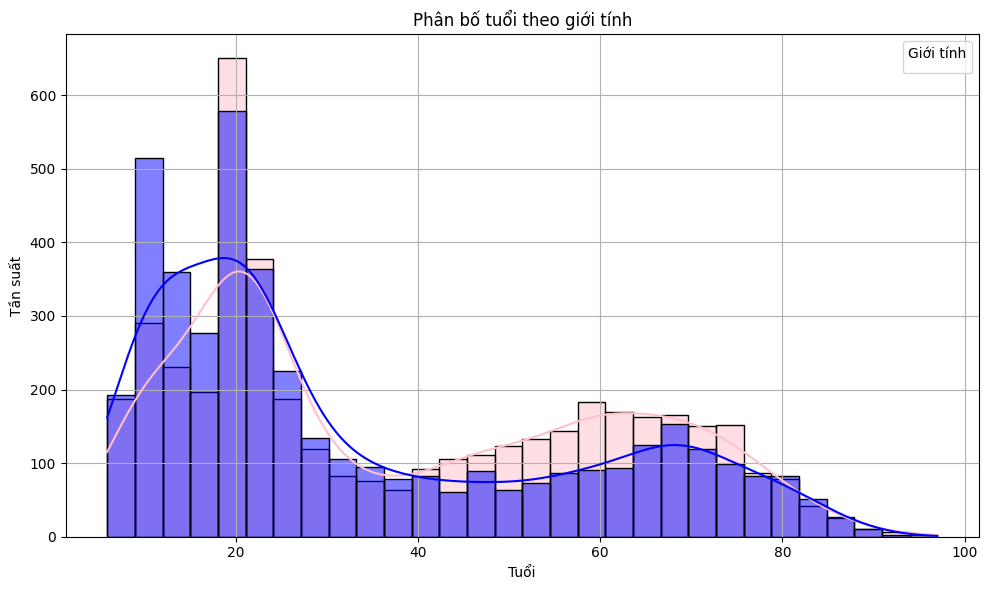

In [7]:
label_ls['subject_age'] = pd.to_numeric(label_ls['subject_age'], errors='coerce')
label_ls = label_ls.dropna(subset=['subject_age'])

plt.figure(figsize=(10, 6))

sns.histplot(data=label_ls, x="subject_age", hue="subject_sex", bins=30, kde=True, 
             palette={"m": "blue", "f": "pink"}, edgecolor="black", discrete=False)

plt.title('Phân bố tuổi theo giới tính')
plt.xlabel('Tuổi')
plt.ylabel('Tần suất')
plt.legend(title='Giới tính')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
subject_metadata = label_ls[['subject_sex','subject_id','dataset_name','subject_age']]
subject_metadata

,subject_sex,subject_id,dataset_name,subject_age
19,m,sub-BrainAge000019,ABIDE/Caltech,44.2
20,m,sub-BrainAge000020,ABIDE/Caltech,39.3
21,m,sub-BrainAge000021,ABIDE/Caltech,42.5
22,m,sub-BrainAge000022,ABIDE/Caltech,19.7
23,f,sub-BrainAge000023,ABIDE/Caltech,20.0
...,...,...,...,...
23209,f,sub-BrainAge023209,RocklandSample,66.0
23210,m,sub-BrainAge023210,RocklandSample,69.0
23211,m,sub-BrainAge023211,RocklandSample,23.0
23212,f,sub-BrainAge023212,RocklandSample,54.0


In [9]:
subject_metadata_dict = label_ls.set_index('subject_id')[['subject_sex','dataset_name','subject_age']].to_dict(orient='index')
len(subject_metadata_dict)

8717

In [10]:
class MRIDataset(Dataset):
    def __init__(self, im_dir, label_ls, transform=None, im_filenames=None):
        self.im_dir = Path(im_dir)
        self.label_ls = label_ls
        self.transform = transform

        if im_filenames is not None:
            self.im_filenames = im_filenames
        else:
            self.im_filenames = self._gather_valid_paths()

    def _gather_valid_paths(self):
        paths = self.im_dir.glob("*/*/*/*.nii")
        valid_paths = []
        fail_paths = {
            self.im_dir / "sub-BrainAge005600/anat/sub-BrainAge005600_T1w.nii/sub-BrainAge005600_T1w.nii"
        }

        for path in paths:
            if not path.is_file():
                continue
                
            if path in fail_paths:
                continue
                
            subject_id = self._extract_subject_id(path)
            if subject_id not in self.label_ls:
                continue
            try:
                # nib.load(path).get_fdata()
                nib.load(path)
                valid_paths.append(path)
            except Exception:
                continue
        return valid_paths

    def _extract_subject_id(self, path):
        for part in Path(path).parts:
            if part.startswith("sub-BrainAge"):
                return part  # ví dụ: "sub-BrainAge000000"
        return None

    def _normalize(self, im):
        im = (im - np.min(im)) / (np.max(im) - np.min(im) + 1e-5)
        return im.astype(np.float32)

    def _get_label(self, subject_id):
        sex = self.label_ls.get(subject_id, {}).get("subject_sex")
        if sex == 'm':
            return 0
        elif sex == 'f':
            return 1
        else:
            raise ValueError(f"Invalid label for subject {subject_id}: {sex}")
            
    def _get_age(self, subject_id):
        return self.label_ls.get(subject_id, {}).get("subject_age")
    
    def __len__(self):
        return len(self.im_filenames)

    def __getitem__(self, idx):
        im_path = self.im_filenames[idx]
        subject_id = self._extract_subject_id(im_path)

        im = nib.load(im_path).get_fdata()
        im = self._normalize(im)

        mid_slice = im.shape[2] // 2
        im_slice = im[:, :, mid_slice]
        
        image_2d = np.stack([im_slice]*3, axis=0)
        image_tensor = torch.from_numpy(image_2d).float()

        if self.transform:
            image_tensor = self.transform(image_tensor)

        label = self._get_label(subject_id)
        return image_tensor, torch.tensor(label, dtype=torch.float32)

In [11]:
def create_global_bin_pool(data: MRIDataset) -> dict:
    subject_metadata = data.label_ls
    subject_ids = [data._extract_subject_id(path) for path in data.im_filenames]

    age_array = np.array([
        subject_metadata.get(sid, {}).get("subject_age", np.nan)
        for sid in subject_ids
    ], dtype=np.float32)

    valid_mask = ~np.isnan(age_array)
    valid_indices = np.arange(len(data.im_filenames))[valid_mask]
    age_array = age_array[valid_mask]

    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    age_bins = np.digitize(age_array, bins, right=False)

    global_bin_pool = {}
    for bin_id in np.unique(age_bins):
        bin_indices = valid_indices[age_bins == bin_id]
        global_bin_pool[bin_id] = set(bin_indices.tolist())

    return global_bin_pool


def get_sample_data(
    data: MRIDataset,
    overlap: float,
    partition_id: int,
    num_partitions: int,
    global_bin_pool: dict,
    num_samples: int = None,
) -> list:
    subject_metadata = data.label_ls
    subject_ids = [data._extract_subject_id(path) for path in data.im_filenames]

    age_array = np.array(
        [subject_metadata.get(sid, {}).get("subject_age", np.nan) for sid in subject_ids],
        dtype=np.float32
    )

    valid_mask = ~np.isnan(age_array)
    valid_indices = np.arange(len(data.im_filenames))[valid_mask]
    age_array = age_array[valid_mask]

    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    age_bins = np.digitize(age_array, bins, right=False)
    total_samples = len(valid_indices)
    client_sample_count = total_samples // num_partitions

    rng = np.random.default_rng(seed=partition_id + 42)
    sampled_indices = set()
    used_bins = set()

    all_bins = list(global_bin_pool.keys())
    rng.shuffle(all_bins)
    target_num_bins = max(1, int(overlap * len(all_bins)))

    # Vòng lặp đến khi đủ sample
    while len(sampled_indices) < client_sample_count:
        # Chọn bin chưa dùng
        candidate_bins = [b for b in all_bins if b not in used_bins]
        if not candidate_bins:
            break  # Không còn bin nào để lấy

        selected_bins = candidate_bins[:target_num_bins]
        used_bins.update(selected_bins)

        # Lấy toàn bộ samples từ các bin đã chọn
        combined_indices = []
        for bin_id in selected_bins:
            available = global_bin_pool[bin_id]
            combined_indices.extend(list(available))

        rng.shuffle(combined_indices)

        # Chọn mẫu đến khi đủ
        needed = client_sample_count - len(sampled_indices)
        to_take = combined_indices[:needed]
        sampled_indices.update(to_take)

        # Xoá mẫu đã chọn khỏi global_bin_pool
        for idx in to_take:
            for bin_id in selected_bins:
                global_bin_pool[bin_id].discard(idx)

    if num_samples and num_samples > client_sample_count:
        remaining_needed = num_samples - client_sample_count
        remaining_pool = list(set(valid_indices) - sampled_indices)
        rng.shuffle(remaining_pool)
        extra = remaining_pool[:remaining_needed]
        sampled_indices.update(extra)

    return list(sampled_indices)

In [12]:
def load_client_datasets(partition_id: int, num_partitions: int, dataset, overlap: int, global_bin_pool: dict, num_samples=None):
    data = dataset
    sampled_indices = get_sample_data(data=data, overlap=overlap, partition_id=partition_id, num_partitions=num_partitions, 
                                      global_bin_pool=global_bin_pool, num_samples=num_samples)

    np.random.shuffle(sampled_indices)
    train_size = int(0.8 * len(sampled_indices))
    train_indices = sampled_indices[:train_size]
    val_indices = sampled_indices[train_size:]

    train_subset = Subset(data, train_indices)
    val_subset = Subset(data, val_indices)
    return train_subset, val_subset

In [13]:
def load_server_test_datasets(data: MRIDataset):
    testloader = DataLoader(data, batch_size=8, shuffle=False)
    return testloader

In [14]:
import json

def load_filenames(input_path):
    input_path = Path(input_path)
    if not input_path.is_file():
        raise FileNotFoundError(f"File {input_path} không tồn tại")
    with open(input_path, 'r') as f:
        return [Path(path) for path in json.load(f)]

In [15]:
im_filenames = load_filenames("/kaggle/input/mri-dataset/mri_dataset.json")

In [16]:
dataset = MRIDataset(data_dir, subject_metadata_dict, im_filenames = im_filenames)
len(dataset)

4948

In [17]:
def save_filenames(im_filenames, output_path):
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    with open(output_path, 'w') as f:
        json.dump([str(path) for path in im_filenames], f)
    print(f"Đã lưu im_filenames vào: {output_path}")

In [18]:
from sklearn.model_selection import train_test_split

all_filenames = dataset.im_filenames

# Chia train/test 
train_filenames, test_filenames = train_test_split(
    all_filenames, test_size=0.2, random_state=42, shuffle=True
)

trainset = MRIDataset(
    im_dir=dataset.im_dir,
    label_ls=dataset.label_ls,
    transform=dataset.transform,
    im_filenames=train_filenames
)

testset = MRIDataset(
    im_dir=dataset.im_dir,
    label_ls=dataset.label_ls,
    transform=dataset.transform,
    im_filenames=test_filenames
)

In [19]:
from typing import List, Dict, Tuple, Optional, Union
import torch.nn as nn 
#import hydra 
from omegaconf import DictConfig, OmegaConf
import logging 
import wandb 
import os 
import warnings
#import lightning as pl 

In [20]:
global_bin_pool = create_global_bin_pool(trainset)

In [21]:
from torchsummary import summary

In [22]:
import torch
import torch.nn as nn
import torchvision.models as models

class BrainMRINet(nn.Module):
    def __init__(self, num_classes: int = 1, pretrained: bool = True):
        super(BrainMRINet, self).__init__()
        # Load DenseNet-121
        densenet = models.densenet121(weights='IMAGENET1K_V1')

        # Replace the classifier (classifier is a single Linear layer in DenseNet)
        num_features = densenet.classifier.in_features
        densenet.classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        self.model = densenet

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


In [23]:
from torchinfo import summary

In [24]:
model = BrainMRINet().to(DEVICE)
summary(model, input_size=(1, 3, 130, 130))

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 151MB/s] 


Layer (type:depth-idx)                        Output Shape              Param #
BrainMRINet                                   [1, 1]                    --
├─DenseNet: 1-1                               [1, 1]                    --
│    └─Sequential: 2-1                        [1, 1024, 4, 4]           --
│    │    └─Conv2d: 3-1                       [1, 64, 65, 65]           9,408
│    │    └─BatchNorm2d: 3-2                  [1, 64, 65, 65]           128
│    │    └─ReLU: 3-3                         [1, 64, 65, 65]           --
│    │    └─MaxPool2d: 3-4                    [1, 64, 33, 33]           --
│    │    └─_DenseBlock: 3-5                  [1, 256, 33, 33]          335,040
│    │    └─_Transition: 3-6                  [1, 128, 16, 16]          33,280
│    │    └─_DenseBlock: 3-7                  [1, 512, 16, 16]          919,680
│    │    └─_Transition: 3-8                  [1, 256, 8, 8]            132,096
│    │    └─_DenseBlock: 3-9                  [1, 1024, 8, 8]           

In [25]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

# Cập nhật tham số mô hình
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def save_model_parameters(parameters, file_path: str = "ckpt.pth"):
    if parameters is None:
        print("No parameters available to save.")
        return
    net = model.to(DEVICE)
    final_ndarrays = parameters_to_ndarrays(parameters)
    set_parameters(net, final_ndarrays)
    torch.save(net.state_dict(), file_path)
    print(f"Model parameters saved to {file_path}")

def get_flat_params(net) -> torch.Tensor:
    return torch.cat([param.data.view(-1) for param in net.parameters()])

def train(net, trainloader, epochs: int, lr: float, id: int, global_params: torch.Tensor = None) -> Tuple[float, float]:
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=1e-2)
    net.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(trainloader, desc=f"[Client {id} Epoch {epoch+1}/{epochs}]", position=id, leave=False, disable=True)
        for images, labels in progress_bar:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE).float()
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels.unsqueeze(1))

            if MU > 0.0 and global_params is not None:
                current_params = get_flat_params(net)
                prox_term = (MU / 2) * torch.norm(current_params - global_params) ** 2
                loss += prox_term
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * labels.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
            
            progress_bar.set_postfix(loss=loss.item())
        
        avg_epoch_loss = epoch_loss / len(trainloader.dataset)
        print(f"[Client {id}] Epoch {epoch+1}/{epochs} - Loss: {avg_epoch_loss:.4f}")
        total_loss += epoch_loss
    
    avg_loss = total_loss / (len(trainloader.dataset) * epochs)
    accuracy = correct / total if total > 0 else 0.0
    print(f"[Client {id}] Train Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
    return avg_loss, accuracy

def test(net, testloader, id: int, server_test=False) -> Tuple[float, float]:
    criterion = nn.BCEWithLogitsLoss()
    net.eval()
    loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(testloader, desc=f"[Client {id}] Testing", position=id, leave=False, disable=True)
        for images, labels in progress_bar:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE).float()
            outputs = net(images)
            loss += criterion(outputs, labels.unsqueeze(1)).item() * labels.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
            progress_bar.set_postfix(loss=loss/total)
    
    avg_loss = loss / len(testloader.dataset) if len(testloader.dataset) > 0 else 0.0
    accuracy = correct / total if total > 0 else 0.0
    if server_test:
        print(f"[Server Test] Test Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
    else:
        print(f"[Client {id}] Test Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
    return avg_loss, accuracy

In [26]:
#def is_dropout(partition_id: int, num_partitions: int) -> bool:
#    return random.random() < DROPOUT

# Định nghĩa Client
class FlowerClient(Client):
    def __init__(self, partition_id, net, trainloader, valloader, num_partitions):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.num_partitions = num_partitions
        self.previous_parameters = None

    def get_parameters(self, ins: GetParametersIns) -> GetParametersRes:
        print(f"[Client {self.partition_id}] get_parameters")
        ndarrays = get_parameters(self.net)
        parameters = ndarrays_to_parameters(ndarrays)
        status = Status(code=Code.OK, message="Success")
        return GetParametersRes(status=status, parameters=parameters)

    def fit(self, ins: FitIns) -> FitRes:
        #if is_dropout(self.partition_id, self.num_partitions):
        #    print(f"[Client {self.partition_id}] dropped out in round {ins.config.get('server_round')}")
        #    status = Status(code=CustomCode.DROPPED_OUT, message="Client dropped out")
        #    return FitRes(
        #        status=status,
        #        parameters=ins.parameters,
        #        num_examples=0,
        #        metrics={}
        #    )
        print(f"[Client {self.partition_id}] fit, config: {ins.config}")

        ndarrays_original = parameters_to_ndarrays(ins.parameters)
        set_parameters(self.net, ndarrays_original)

        global_params = get_flat_params(self.net).clone().detach()
        
        lr = ins.config.get("lr", 0.01)
        epochs = ins.config.get("epochs", 1)
        train_loss, train_accuracy = train(self.net, self.trainloader, epochs=epochs, lr=lr, id=self.partition_id, global_params=global_params)

        ndarrays_updated = get_parameters(self.net)
        parameters_updated = ndarrays_to_parameters(ndarrays_updated)
        self.previous_parameters = parameters_updated

        status = Status(code=Code.OK, message="Success")
        return FitRes(
            status=status,
            parameters=parameters_updated,
            num_examples=len(self.trainloader.dataset),
            metrics={
                "train_loss": float(train_loss),
                "train_accuracy": float(train_accuracy)
            }
        )

    def evaluate(self, ins: EvaluateIns) -> EvaluateRes:
        #if is_dropout(self.partition_id, self.num_partitions):
        #    print(f"[Client {self.partition_id}] dropped out in evaluation round {ins.config.get('server_round')}")
        #    status = Status(code=CustomCode.DROPPED_OUT, message="Client dropped out")
        #    return EvaluateRes(
        #        status=status,
        #        loss=0.0,
        #        num_examples=0,
        #        metrics={}
        #    )

        print(f"[Client {self.partition_id}] evaluate, config: {ins.config}")

        ndarrays_original = parameters_to_ndarrays(ins.parameters)
        set_parameters(self.net, ndarrays_original)

        val_loss, val_accuracy = test(self.net, self.valloader, self.partition_id)
        status = Status(code=Code.OK, message="Success")
        return EvaluateRes(
            status=status,
            loss=float(val_loss),
            num_examples=len(self.valloader.dataset),
            metrics={"val_accuracy": float(val_accuracy)}
        )

# Hàm tạo client
def client_fn(context: Context) -> Client:
    net = model.to(DEVICE)
    partition_id = int(context.node_config["partition-id"])
    num_partitions = context.node_config["num-partitions"]
    
    train_subset, val_subset = load_client_datasets(partition_id, num_partitions, dataset=trainset, overlap=0.6, global_bin_pool=global_bin_pool)
    trainloader = DataLoader(train_subset, batch_size=BATCHSIZE, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=BATCHSIZE, shuffle=False)
    
    return FlowerClient(partition_id, net, trainloader, valloader, num_partitions).to_client()

# Client
client = ClientApp(client_fn=client_fn)

In [27]:
config={
    "num_client": NUM_CLIENTS,
    "num_rounds": NUM_ROUNDS,
    "dropout": DROPOUT,
    "learning_rate": LR,
    "architecture": "2DNet",
    "dataset": "Mri",
    "epochs_round": epochs_round,
    "overlap": OVERLAP,
}
print(config)


{'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}


In [28]:
from flwr.server.strategy.aggregate import aggregate, aggregate_inplace, weighted_loss_avg

In [29]:
class FedProx(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0 - DROPOUT,
        fraction_evaluate: float = 1.0 - DROPOUT,
        min_fit_clients: int = 1,
        min_evaluate_clients: int = 1,
        min_available_clients: int = 1,
        evaluate_fn: Optional[Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]] = None,
        proximal_mu: float = MU,
        inplace: bool = True,
        initial_parameters: Optional[Parameters] = None,
    ):
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.proximal_mu = proximal_mu
        self.current_params = initial_parameters
        self.inplace = inplace

    def initialize_parameters(self, client_manager: ClientManager) -> Optional[Parameters]:
        net = model
        current_params = get_parameters(net)
        return ndarrays_to_parameters(current_params)

    def num_fit_clients(self, num_available_clients: int) -> tuple[int, int]:
        """Return the sample size and the required number of available clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

    
    
    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager) -> List[Tuple[ClientProxy, FitIns]]:
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        standard_config = {"lr": LR,
                           "proximal mu": self.proximal_mu,
                           "epochs": epochs_round,
                           "server_round": server_round}
        fit_ins = FitIns(parameters, config)
        return [(client, fit_ins) for client in clients]
    
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]]
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        if not results:
            return None, {}

        #valid_results = [(client_proxy, res) for client_proxy, res in results if res.status.code == Code.OK]
        #if not valid_results:
        #    return None, {}

        if self.inplace:
            aggregated_ndarrays = aggregate_inplace(results)
        else:
            weights_results = [
                (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
                for _, fit_res in results
            ]
            aggregated_ndarrays = aggregate(weights_results)

        parameters_aggregated = ndarrays_to_parameters(aggregated_ndarrays)
        self.current_params = parameters_aggregated

        # save model
        if wandb_log:
            if server_round % 2 == 0:
                save_model_parameters(parameters_aggregated, file_path="final_model.pth")

        total_examples = sum(res.num_examples for _, res in results)
        train_loss_agg = sum(
            res.num_examples * res.metrics["train_loss"] for _, res in results
        ) / total_examples if total_examples > 0 else 0.0
        train_accuracy_agg = sum(
            res.num_examples * res.metrics["train_accuracy"] for _, res in results
        ) / total_examples if total_examples > 0 else 0.0

        metrics_aggregated = {
            "train_loss": train_loss_agg,
            "train_accuracy": train_accuracy_agg,
            "clients_participated": len(results)
        }

        if wandb_log:
            wandb_logger.log({
                "round": server_round,
                "train_loss": train_loss_agg,
                "train_accuracy": train_accuracy_agg,
                "clients_participated_fit": len(results)
            })

        HISTORY["train_loss"].append(train_loss_agg)
        HISTORY["train_accuracy"].append(train_accuracy_agg)
        HISTORY["clients_participated_fit"].append(len(results))

        return parameters_aggregated, metrics_aggregated

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        if self.fraction_evaluate == 0.0:
            return []
        config = {"server_round": server_round}
        evaluate_ins = EvaluateIns(parameters, config)
        sample_size, min_num_clients = self.num_evaluation_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]]
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        if not results:
            print(f"Round {server_round}: No results received")
            return None, {"val_accuracy": 0.0, "clients_participated": 0}

        #valid_results = [
        #    (client_proxy, res) for client_proxy, res in results
        #    if res.status.code == Code.OK
        #]
        #if not valid_results:
        #    print(f"Round {server_round}: No valid evaluation results")
        #    return None, {"val_accuracy": 0.0, "clients_participated": 0}

        total_examples = sum(res.num_examples for _, res in results)
        loss_aggregated = flwr.server.strategy.aggregate.weighted_loss_avg(
            [(res.num_examples, res.loss) for _, res in results]
        )
        val_accuracy_aggregated = sum(
            res.num_examples * res.metrics["val_accuracy"] for _, res in results
        ) / total_examples if total_examples > 0 else 0.0

        metrics_aggregated = {
            "val_loss": loss_aggregated,
            "val_accuracy": val_accuracy_aggregated,
            "clients_participated": len(results)
        }

        if wandb_log:
            wandb_logger.log({
                "round": server_round,
                "val_loss": loss_aggregated,
                "val_accuracy": val_accuracy_aggregated,
                "clients_participated_eval": len(results)
            })

        HISTORY["val_loss"].append(loss_aggregated)
        HISTORY["val_accuracy"].append(val_accuracy_aggregated)
        HISTORY["clients_participated_eval"].append(len(results))

        return loss_aggregated, metrics_aggregated

    def evaluate(self, server_round: int, parameters: Parameters) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        if server_round == 0 or self.evaluate_fn is None:
            return None
        parameters_ndarrays = parameters_to_ndarrays(self.current_params)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        return eval_res

    #def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
    #    num_clients = int(num_available_clients * self.fraction_fit)
    #    return max(num_clients, self.min_fit_clients), self.min_available_clients

    #def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
    #    num_clients = int(num_available_clients * self.fraction_evaluate)
    #    return max(num_clients, self.min_evaluate_clients), self.min_available_clients

# Hàm đánh giá trên server
def evaluate_fn(server_round: int, parameters: NDArrays, config: Dict[str, Scalar]) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    net = model.to(DEVICE)
    set_parameters(net, parameters)
    testloader = load_server_test_datasets(data=testset)
    test_loss, test_accuracy = test(net, testloader, id=-1, server_test=True)

    if wandb_log:
        wandb_logger.log({
            "round": server_round,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy
        })
    
    HISTORY["test_loss"].append(test_loss)
    HISTORY["test_accuracy"].append(test_accuracy)
    
    return test_loss, {"test_accuracy": test_accuracy}

# Server
def server_fn(context: Context) -> ServerAppComponents:
    strategy = FedProx(
        evaluate_fn=evaluate_fn
    )
    config = ServerConfig(num_rounds=NUM_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [30]:
from kaggle_secrets import UserSecretsClient
import wandb
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb api key")
wandb.login(key=wandb_api_key)
wandb_log = True

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sang2222004 (sang2222004-uet-vnu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [31]:
import time

if wandb_log:
    current_time = time.strftime("%Y-%m-%d_%H-%M-%S")
    wandb_logger = wandb.init(
        project="sex-classification",
        name=f"{current_time} + 0.7",
        tags = ['300-samples','TrungNet', 'fedar'],
        config={
            "num_client": NUM_CLIENTS,
            "num_rounds": NUM_ROUNDS,
            "dropout": DROPOUT,
            "learning_rate": LR,
            "architecture": "BrainMRINet",
            "dataset": "mri",
            "epochs_round": epochs_round,
        },
    )

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [32]:
import logging
import absl.logging

logging.basicConfig(level=logging.INFO)
absl.logging.set_verbosity(absl.logging.INFO)

# Cấu hình backend
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0}}
if DEVICE.type == "cuda":
    backend_config["client_resources"]["num_gpus"] = 1

model = BrainMRINet()
client = ClientApp(client_fn=client_fn)
server = ServerApp(server_fn=server_fn)

# Khởi tạo HISTORY
HISTORY = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
    "test_loss": [],
    "test_accuracy": [],
    "clients_participated_fit": [],
    "clients_participated_eval": []
}

# Chạy simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

if wandb_log:
    wandb_logger.finish()

INFO :      Starting Flower ServerApp, config: num_rounds=30, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)
(pid=402) 2025-06-02 10:30:53.026710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=402) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=402) E0000 00:00:1748860253.055135     402 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=402) E0000 00:00:1748860253.062692     402 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attemp

(ClientAppActor pid=402) [Client 1] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 0] Epoch 1/1 - Loss: 0.7240
(ClientAppActor pid=403) [Client 0] Train Loss: 0.7240 | Accuracy: 43.99%
(ClientAppActor pid=403) [Client 0] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 7] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 6] Epoch 1/1 - Loss: 0.7207 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-loggin

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=403) [Client 9] Epoch 1/1 - Loss: 0.7101 [repeated 2x across cluster]
(ClientAppActor pid=403) [Client 9] Train Loss: 0.7101 | Accuracy: 50.95% [repeated 2x across cluster]


INFO :      fit progress: (1, 0.6672715972168277, {'test_accuracy': 0.5909090909090909}, 198.94007033000003)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.6673 | Accuracy: 59.09%
(ClientAppActor pid=403) [Client 3] evaluate, config: {'server_round': 1}
(ClientAppActor pid=403) [Client 3] Test Loss: 0.6849 | Accuracy: 56.96%
(ClientAppActor pid=402) [Client 5] evaluate, config: {'server_round': 1}
(ClientAppActor pid=403) [Client 6] evaluate, config: {'server_round': 1}
(ClientAppActor pid=402) [Client 8] Test Loss: 0.6492 | Accuracy: 64.56% [repeated 3x across cluster]
(ClientAppActor pid=403) [Client 4] evaluate, config: {'server_round': 1} [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=403) [Client 1] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 3] Epoch 1/1 - Loss: 0.6800
(ClientAppActor pid=402) [Client 3] Train Loss: 0.6800 | Accuracy: 58.54%
(ClientAppActor pid=403) [Client 4] Test Loss: 0.6634 | Accuracy: 58.23%
(ClientAppActor pid=402) [Client 3] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 4] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 4] Epoch 1/1 - Loss: 0.6909 [repeated 2x across cluster]
(ClientAppActor pid=402) [Client 4] Train Loss: 0.6909 | Accuracy: 55.06% [repeated 2x across cl

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=402) [Client 7] Epoch 1/1 - Loss: 0.6729 [repeated 2x across cluster]
(ClientAppActor pid=402) [Client 7] Train Loss: 0.6729 | Accuracy: 59.18% [repeated 2x across cluster]
Model parameters saved to final_model.pth


INFO :      fit progress: (2, 0.6608828224316992, {'test_accuracy': 0.597979797979798}, 371.03104163700004)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.6609 | Accuracy: 59.80%
(ClientAppActor pid=403) [Client 3] evaluate, config: {'server_round': 2}
(ClientAppActor pid=403) [Client 3] Test Loss: 0.7041 | Accuracy: 44.30%
(ClientAppActor pid=403) [Client 5] evaluate, config: {'server_round': 2} [repeated 3x across cluster]
(ClientAppActor pid=402) [Client 6] Test Loss: 0.6441 | Accuracy: 68.35% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=403) [Client 8] evaluate, config: {'server_round': 2}
(ClientAppActor pid=403) [Client 0] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 8] Test Loss: 0.6638 | Accuracy: 55.70%
(ClientAppActor pid=402) [Client 1] Epoch 1/1 - Loss: 0.6692
(ClientAppActor pid=402) [Client 1] Train Loss: 0.6692 | Accuracy: 59.49%
(ClientAppActor pid=402) [Client 1] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 3] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 0] Epoch 1/1 - Loss: 0.6703
(ClientAppActor pid=403) [Client 0] Train Loss: 0.6

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=402) [Client 8] Epoch 1/1 - Loss: 0.6642
(ClientAppActor pid=402) [Client 8] Train Loss: 0.6642 | Accuracy: 62.66%


INFO :      fit progress: (3, 0.6545906493158051, {'test_accuracy': 0.5828282828282828}, 459.10111721499993)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.6546 | Accuracy: 58.28%
(ClientAppActor pid=403) [Client 3] evaluate, config: {'server_round': 3}
(ClientAppActor pid=402) [Client 1] Test Loss: 0.6376 | Accuracy: 68.35%
(ClientAppActor pid=402) [Client 4] evaluate, config: {'server_round': 3} [repeated 3x across cluster]
(ClientAppActor pid=402) [Client 4] Test Loss: 0.6578 | Accuracy: 62.03% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=403) [Client 9] evaluate, config: {'server_round': 3}
(ClientAppActor pid=402) [Client 2] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 0] Epoch 1/1 - Loss: 0.6502
(ClientAppActor pid=403) [Client 0] Train Loss: 0.6502 | Accuracy: 63.92%
(ClientAppActor pid=403) [Client 9] Test Loss: 0.6617 | Accuracy: 56.96%
(ClientAppActor pid=403) [Client 0] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 4] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 2] Epoch 1/1 - Loss: 0.6313
(ClientAppActor pid=402) [Client 2] Train Loss: 0.6

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=402) [Client 7] Epoch 1/1 - Loss: 0.6470 [repeated 2x across cluster]
(ClientAppActor pid=402) [Client 7] Train Loss: 0.6470 | Accuracy: 63.29% [repeated 2x across cluster]
Model parameters saved to final_model.pth


INFO :      fit progress: (4, 0.6496776022092261, {'test_accuracy': 0.5818181818181818}, 550.7806783600001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.6497 | Accuracy: 58.18%
(ClientAppActor pid=403) [Client 4] evaluate, config: {'server_round': 4}
(ClientAppActor pid=402) [Client 2] Test Loss: 0.6247 | Accuracy: 68.35%
(ClientAppActor pid=402) [Client 6] evaluate, config: {'server_round': 4} [repeated 3x across cluster]
(ClientAppActor pid=402) [Client 6] Test Loss: 0.6608 | Accuracy: 56.96% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=403) [Client 1] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 8] evaluate, config: {'server_round': 4}
(ClientAppActor pid=402) [Client 5] Epoch 1/1 - Loss: 0.6202
(ClientAppActor pid=402) [Client 5] Train Loss: 0.6202 | Accuracy: 64.56%
(ClientAppActor pid=403) [Client 8] Test Loss: 0.6652 | Accuracy: 55.70%
(ClientAppActor pid=402) [Client 5] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 7] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 7] Epoch 1/1 - Loss: 0.6170 [repeated 2x across cluster]
(ClientAppActor pid=40

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=402) [Client 9] Epoch 1/1 - Loss: 0.6318
(ClientAppActor pid=402) [Client 9] Train Loss: 0.6318 | Accuracy: 65.51%


INFO :      fit progress: (5, 0.6405915296438969, {'test_accuracy': 0.601010101010101}, 646.669223487)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.6406 | Accuracy: 60.10%
(ClientAppActor pid=402) [Client 3] evaluate, config: {'server_round': 5}
(ClientAppActor pid=403) [Client 5] Test Loss: 0.6219 | Accuracy: 64.56%
(ClientAppActor pid=402) [Client 8] evaluate, config: {'server_round': 5} [repeated 3x across cluster]
(ClientAppActor pid=403) [Client 6] Test Loss: 0.6630 | Accuracy: 59.49% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=402) [Client 9] evaluate, config: {'server_round': 5}
(ClientAppActor pid=402) [Client 9] Test Loss: 0.6717 | Accuracy: 54.43%
(ClientAppActor pid=403) [Client 4] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 4] Epoch 1/1 - Loss: 0.6194
(ClientAppActor pid=403) [Client 4] Train Loss: 0.6194 | Accuracy: 65.19%
(ClientAppActor pid=402) [Client 1] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 5] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 5] Epoch 1/1 - Loss: 0.5947 [repeated 2x across cluster]
(ClientAppActor pid=40

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=403) [Client 8] Epoch 1/1 - Loss: 0.5989 [repeated 2x across cluster]
(ClientAppActor pid=403) [Client 8] Train Loss: 0.5989 | Accuracy: 71.20% [repeated 2x across cluster]
Model parameters saved to final_model.pth


INFO :      fit progress: (6, 0.633980579809709, {'test_accuracy': 0.6111111111111112}, 725.5160283409998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.6340 | Accuracy: 61.11%
(ClientAppActor pid=403) [Client 5] evaluate, config: {'server_round': 6}
(ClientAppActor pid=403) [Client 5] Test Loss: 0.6407 | Accuracy: 54.43%
(ClientAppActor pid=402) [Client 3] evaluate, config: {'server_round': 6} [repeated 3x across cluster]
(ClientAppActor pid=403) [Client 9] Test Loss: 0.6160 | Accuracy: 68.35% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=403) [Client 3] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 2] Epoch 1/1 - Loss: 0.5739
(ClientAppActor pid=402) [Client 2] Train Loss: 0.5739 | Accuracy: 73.10%
(ClientAppActor pid=402) [Client 7] evaluate, config: {'server_round': 6}
(ClientAppActor pid=402) [Client 7] Test Loss: 0.6702 | Accuracy: 56.96%
(ClientAppActor pid=402) [Client 2] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 4] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 7] Epoch 1/1 - Loss: 0.6031 [repeated 2x across cluster]
(ClientAppActor pid=40

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=403) [Client 8] Epoch 1/1 - Loss: 0.5900 [repeated 2x across cluster]
(ClientAppActor pid=403) [Client 8] Train Loss: 0.5900 | Accuracy: 69.94% [repeated 2x across cluster]


INFO :      fit progress: (7, 0.6297503919312448, {'test_accuracy': 0.6151515151515151}, 818.5098731109999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.6298 | Accuracy: 61.52%
(ClientAppActor pid=403) [Client 0] evaluate, config: {'server_round': 7}
(ClientAppActor pid=402) [Client 1] Test Loss: 0.5900 | Accuracy: 73.42%
(ClientAppActor pid=402) [Client 2] evaluate, config: {'server_round': 7} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=402) [Client 8] Test Loss: 0.6316 | Accuracy: 60.76% [repeated 4x across cluster]
(ClientAppActor pid=403) [Client 1] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 1] Epoch 1/1 - Loss: 0.6062
(ClientAppActor pid=403) [Client 1] Train Loss: 0.6062 | Accuracy: 66.14%
(ClientAppActor pid=402) [Client 8] evaluate, config: {'server_round': 7}
(ClientAppActor pid=402) [Client 0] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 3] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 3] Epoch 1/1 - Loss: 0.6031 [repeated 2x across cl

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=403) [Client 8] Epoch 1/1 - Loss: 0.5625 [repeated 2x across cluster]
(ClientAppActor pid=403) [Client 8] Train Loss: 0.5625 | Accuracy: 76.27% [repeated 2x across cluster]
Model parameters saved to final_model.pth


INFO :      fit progress: (8, 0.6246103652799972, {'test_accuracy': 0.6080808080808081}, 898.5905407309999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.6246 | Accuracy: 60.81%
(ClientAppActor pid=403) [Client 0] evaluate, config: {'server_round': 8}
(ClientAppActor pid=403) [Client 0] Test Loss: 0.5924 | Accuracy: 63.29%
(ClientAppActor pid=402) [Client 4] evaluate, config: {'server_round': 8} [repeated 3x across cluster]
(ClientAppActor pid=402) [Client 4] Test Loss: 0.6714 | Accuracy: 51.90% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=403) [Client 9] evaluate, config: {'server_round': 8}
(ClientAppActor pid=403) [Client 1] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 1] Epoch 1/1 - Loss: 0.5825
(ClientAppActor pid=403) [Client 1] Train Loss: 0.5825 | Accuracy: 71.20%
(ClientAppActor pid=403) [Client 9] Test Loss: 0.6344 | Accuracy: 62.03%
(ClientAppActor pid=402) [Client 4] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 5] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 4] Epoch 1/1 - Loss: 0.5930
(ClientAppActor pid=402) [Client 4] Train Loss: 0.5

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=403) [Client 8] Epoch 1/1 - Loss: 0.5529
(ClientAppActor pid=403) [Client 8] Train Loss: 0.5529 | Accuracy: 73.73%


INFO :      fit progress: (9, 0.6178121959320223, {'test_accuracy': 0.6161616161616161}, 1022.3163129329998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.6178 | Accuracy: 61.62%
(ClientAppActor pid=402) [Client 5] evaluate, config: {'server_round': 9}
(ClientAppActor pid=402) [Client 5] Test Loss: 0.6455 | Accuracy: 56.96%
(ClientAppActor pid=403) [Client 8] evaluate, config: {'server_round': 9} [repeated 3x across cluster]
(ClientAppActor pid=403) [Client 8] Test Loss: 0.6121 | Accuracy: 60.76% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=402) [Client 9] evaluate, config: {'server_round': 9}
(ClientAppActor pid=403) [Client 1] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 9] Test Loss: 0.6114 | Accuracy: 67.09%
(ClientAppActor pid=403) [Client 1] Epoch 1/1 - Loss: 0.5606
(ClientAppActor pid=403) [Client 1] Train Loss: 0.5606 | Accuracy: 73.73%
(ClientAppActor pid=402) [Client 0] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 2] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 2] Epoch 1/1 - Loss: 0.5452 [repeated 2x across cluster]
(ClientAppActor pid=40

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=403) [Client 7] Epoch 1/1 - Loss: 0.5675 [repeated 2x across cluster]
(ClientAppActor pid=403) [Client 7] Train Loss: 0.5675 | Accuracy: 71.84% [repeated 2x across cluster]
Model parameters saved to final_model.pth


INFO :      fit progress: (10, 0.6084311462411977, {'test_accuracy': 0.6373737373737374}, 1109.693960973)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.6084 | Accuracy: 63.74%
(ClientAppActor pid=403) [Client 1] evaluate, config: {'server_round': 10}
(ClientAppActor pid=402) [Client 2] Test Loss: 0.6140 | Accuracy: 62.03%
(ClientAppActor pid=403) [Client 8] evaluate, config: {'server_round': 10} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=402) [Client 6] Test Loss: 0.6468 | Accuracy: 62.03% [repeated 4x across cluster]
(ClientAppActor pid=402) [Client 8] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 6] evaluate, config: {'server_round': 10}
(ClientAppActor pid=402) [Client 8] Epoch 1/1 - Loss: 0.5101
(ClientAppActor pid=402) [Client 8] Train Loss: 0.5101 | Accuracy: 77.85%
(ClientAppActor pid=403) [Client 0] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 2] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 2] Epoch 1/1 - Loss: 0.5274 [repeated 2x across c

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=402) [Client 9] Epoch 1/1 - Loss: 0.5421 [repeated 2x across cluster]
(ClientAppActor pid=402) [Client 9] Train Loss: 0.5421 | Accuracy: 74.05% [repeated 2x across cluster]


INFO :      fit progress: (11, 0.6012027191393303, {'test_accuracy': 0.6484848484848484}, 1196.8643082699998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.6012 | Accuracy: 64.85%
(ClientAppActor pid=403) [Client 2] evaluate, config: {'server_round': 11}
(ClientAppActor pid=403) [Client 2] Test Loss: 0.6172 | Accuracy: 64.56%
(ClientAppActor pid=402) [Client 7] evaluate, config: {'server_round': 11} [repeated 3x across cluster]
(ClientAppActor pid=403) [Client 4] Test Loss: 0.5923 | Accuracy: 65.82% [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=403) [Client 0] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 0] Epoch 1/1 - Loss: 0.5157
(ClientAppActor pid=403) [Client 0] Train Loss: 0.5157 | Accuracy: 78.16%
(ClientAppActor pid=403) [Client 8] evaluate, config: {'server_round': 11}
(ClientAppActor pid=403) [Client 8] Test Loss: 0.6324 | Accuracy: 48.10% [repeated 2x across cluster]
(ClientAppActor pid=402) [Client 4] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 5] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 5] Epoch 1/1 - Loss: 0.4988 [repeated 2x across c

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=403) [Client 9] Epoch 1/1 - Loss: 0.5218 [repeated 2x across cluster]
(ClientAppActor pid=403) [Client 9] Train Loss: 0.5218 | Accuracy: 77.53% [repeated 2x across cluster]
Model parameters saved to final_model.pth


INFO :      fit progress: (12, 0.5835569591233225, {'test_accuracy': 0.6686868686868687}, 1288.58950253)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.5836 | Accuracy: 66.87%
(ClientAppActor pid=403) [Client 1] evaluate, config: {'server_round': 12}
(ClientAppActor pid=402) [Client 4] Test Loss: 0.5898 | Accuracy: 67.09%
(ClientAppActor pid=403) [Client 6] evaluate, config: {'server_round': 12} [repeated 3x across cluster]
(ClientAppActor pid=403) [Client 6] Test Loss: 0.6286 | Accuracy: 62.03% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=403) [Client 3] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 8] evaluate, config: {'server_round': 12}
(ClientAppActor pid=402) [Client 0] Epoch 1/1 - Loss: 0.5138
(ClientAppActor pid=402) [Client 0] Train Loss: 0.5138 | Accuracy: 76.58%
(ClientAppActor pid=402) [Client 8] Test Loss: 0.6232 | Accuracy: 62.03%
(ClientAppActor pid=402) [Client 0] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 4] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 3] Epoch 1/1 - Loss: 0.5422
(ClientAppActor pid=403) [Client 3] Train Loss: 0.

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=402) [Client 8] Epoch 1/1 - Loss: 0.4793 [repeated 2x across cluster]
(ClientAppActor pid=402) [Client 8] Train Loss: 0.4793 | Accuracy: 79.43% [repeated 2x across cluster]


INFO :      fit progress: (13, 0.5627849584878093, {'test_accuracy': 0.7232323232323232}, 1433.0364649209998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.5628 | Accuracy: 72.32%
(ClientAppActor pid=403) [Client 5] evaluate, config: {'server_round': 13}
(ClientAppActor pid=403) [Client 5] Test Loss: 0.5463 | Accuracy: 74.68%
(ClientAppActor pid=403) [Client 6] evaluate, config: {'server_round': 13} [repeated 2x across cluster]
(ClientAppActor pid=403) [Client 6] Test Loss: 0.5962 | Accuracy: 65.82% [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=403) [Client 8] evaluate, config: {'server_round': 13} [repeated 2x across cluster]
(ClientAppActor pid=403) [Client 1] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 4] Epoch 1/1 - Loss: 0.4802
(ClientAppActor pid=402) [Client 4] Train Loss: 0.4802 | Accuracy: 81.01%
(ClientAppActor pid=403) [Client 8] Test Loss: 0.5134 | Accuracy: 82.28% [repeated 2x across cluster]
(ClientAppActor pid=402) [Client 4] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 6] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 6] Epoch 1/1 - Loss:

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=402) [Client 9] Epoch 1/1 - Loss: 0.4820
(ClientAppActor pid=402) [Client 9] Train Loss: 0.4820 | Accuracy: 79.43%
Model parameters saved to final_model.pth


INFO :      fit progress: (14, 0.5457350682730626, {'test_accuracy': 0.7606060606060606}, 1526.436434166)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.5457 | Accuracy: 76.06%
(ClientAppActor pid=403) [Client 4] evaluate, config: {'server_round': 14}
(ClientAppActor pid=403) [Client 4] Test Loss: 0.6154 | Accuracy: 63.29%
(ClientAppActor pid=402) [Client 7] evaluate, config: {'server_round': 14} [repeated 3x across cluster]
(ClientAppActor pid=402) [Client 7] Test Loss: 0.5975 | Accuracy: 72.15% [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=403) [Client 2] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 8] evaluate, config: {'server_round': 14}
(ClientAppActor pid=402) [Client 8] Test Loss: 0.5030 | Accuracy: 77.22% [repeated 2x across cluster]
(ClientAppActor pid=402) [Client 0] Epoch 1/1 - Loss: 0.4533
(ClientAppActor pid=402) [Client 0] Train Loss: 0.4533 | Accuracy: 84.18%
(ClientAppActor pid=402) [Client 0] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 3] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 3] Epoch 1/1 - Loss: 0.4983 [repeated 2x across c

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=402) [Client 9] Epoch 1/1 - Loss: 0.4399
(ClientAppActor pid=402) [Client 9] Train Loss: 0.4399 | Accuracy: 82.91%


INFO :      fit progress: (15, 0.5300365542522585, {'test_accuracy': 0.7818181818181819}, 1618.095963691)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.5300 | Accuracy: 78.18%
(ClientAppActor pid=402) [Client 4] evaluate, config: {'server_round': 15}
(ClientAppActor pid=403) [Client 6] Test Loss: 0.5093 | Accuracy: 79.75%
(ClientAppActor pid=402) [Client 7] evaluate, config: {'server_round': 15} [repeated 3x across cluster]
(ClientAppActor pid=403) [Client 8] Test Loss: 0.5130 | Accuracy: 78.48% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=403) [Client 4] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 4] Epoch 1/1 - Loss: 0.4477
(ClientAppActor pid=403) [Client 4] Train Loss: 0.4477 | Accuracy: 80.38%
(ClientAppActor pid=402) [Client 9] evaluate, config: {'server_round': 15}
(ClientAppActor pid=402) [Client 9] Test Loss: 0.5268 | Accuracy: 73.42%
(ClientAppActor pid=402) [Client 2] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 0] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 0] Epoch 1/1 - Loss: 0.4466 [repeated 2x across cluster]
(ClientAppActor pid=4

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=403) [Client 6] Epoch 1/1 - Loss: 0.4514
(ClientAppActor pid=403) [Client 6] Train Loss: 0.4514 | Accuracy: 82.28%
Model parameters saved to final_model.pth


INFO :      fit progress: (16, 0.5202880905132101, {'test_accuracy': 0.7717171717171717}, 1709.8390803300001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.5203 | Accuracy: 77.17%
(ClientAppActor pid=403) [Client 0] evaluate, config: {'server_round': 16}
(ClientAppActor pid=403) [Client 0] Test Loss: 0.5338 | Accuracy: 69.62%
(ClientAppActor pid=403) [Client 4] evaluate, config: {'server_round': 16} [repeated 2x across cluster]
(ClientAppActor pid=402) [Client 5] Test Loss: 0.5486 | Accuracy: 75.95% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=403) [Client 9] evaluate, config: {'server_round': 16} [repeated 2x across cluster]
(ClientAppActor pid=403) [Client 1] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 2] Epoch 1/1 - Loss: 0.4265
(ClientAppActor pid=402) [Client 2] Train Loss: 0.4265 | Accuracy: 83.54%
(ClientAppActor pid=403) [Client 9] Test Loss: 0.5086 | Accuracy: 74.68%
(ClientAppActor pid=402) [Client 2] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 3] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 5] Epoch 1/1 - Loss: 0.3874 [repeated 2x across c

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=403) [Client 6] Epoch 1/1 - Loss: 0.4223 [repeated 2x across cluster]
(ClientAppActor pid=403) [Client 6] Train Loss: 0.4223 | Accuracy: 83.86% [repeated 2x across cluster]


INFO :      fit progress: (17, 0.4956348623892274, {'test_accuracy': 0.795959595959596}, 1855.214451818)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.4956 | Accuracy: 79.60%
(ClientAppActor pid=403) [Client 0] evaluate, config: {'server_round': 17}
(ClientAppActor pid=402) [Client 3] Test Loss: 0.6301 | Accuracy: 64.56%
(ClientAppActor pid=403) [Client 5] evaluate, config: {'server_round': 17} [repeated 3x across cluster]
(ClientAppActor pid=402) [Client 4] Test Loss: 0.5192 | Accuracy: 75.95% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=402) [Client 1] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 8] evaluate, config: {'server_round': 17}
(ClientAppActor pid=403) [Client 0] Epoch 1/1 - Loss: 0.4076
(ClientAppActor pid=403) [Client 0] Train Loss: 0.4076 | Accuracy: 83.86%
(ClientAppActor pid=403) [Client 8] Test Loss: 0.5314 | Accuracy: 79.75%
(ClientAppActor pid=403) [Client 0] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 3] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 1] Epoch 1/1 - Loss: 0.4075
(ClientAppActor pid=402) [Client 1] Train Loss: 0.

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=403) [Client 9] Epoch 1/1 - Loss: 0.3939
(ClientAppActor pid=403) [Client 9] Train Loss: 0.3939 | Accuracy: 84.81%
Model parameters saved to final_model.pth


INFO :      fit progress: (18, 0.4733730395634969, {'test_accuracy': 0.8444444444444444}, 1949.890344969)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.4734 | Accuracy: 84.44%
(ClientAppActor pid=403) [Client 1] evaluate, config: {'server_round': 18}
(ClientAppActor pid=403) [Client 1] Test Loss: 0.4882 | Accuracy: 86.08%
(ClientAppActor pid=402) [Client 7] evaluate, config: {'server_round': 18} [repeated 3x across cluster]
(ClientAppActor pid=403) [Client 5] Test Loss: 0.4440 | Accuracy: 82.28% [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=403) [Client 1] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 9] evaluate, config: {'server_round': 18}
(ClientAppActor pid=403) [Client 1] Epoch 1/1 - Loss: 0.3831
(ClientAppActor pid=403) [Client 1] Train Loss: 0.3831 | Accuracy: 88.61%
(ClientAppActor pid=403) [Client 9] Test Loss: 0.5226 | Accuracy: 79.75% [repeated 2x across cluster]
(ClientAppActor pid=402) [Client 4] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 5] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 4] Epoch 1/1 - Loss: 0.3975
(ClientAppActor pid=4

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=403) [Client 8] Epoch 1/1 - Loss: 0.3925
(ClientAppActor pid=403) [Client 8] Train Loss: 0.3925 | Accuracy: 84.49%


INFO :      fit progress: (19, 0.45459155687178027, {'test_accuracy': 0.8626262626262626}, 2031.144376808)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.4546 | Accuracy: 86.26%
(ClientAppActor pid=403) [Client 1] evaluate, config: {'server_round': 19}
(ClientAppActor pid=403) [Client 1] Test Loss: 0.4546 | Accuracy: 89.87%
(ClientAppActor pid=402) [Client 7] evaluate, config: {'server_round': 19} [repeated 3x across cluster]
(ClientAppActor pid=402) [Client 7] Test Loss: 0.4836 | Accuracy: 83.54% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=403) [Client 9] evaluate, config: {'server_round': 19}
(ClientAppActor pid=402) [Client 1] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 1] Epoch 1/1 - Loss: 0.3668
(ClientAppActor pid=402) [Client 1] Train Loss: 0.3668 | Accuracy: 86.08%
(ClientAppActor pid=403) [Client 9] Test Loss: 0.4327 | Accuracy: 83.54%
(ClientAppActor pid=403) [Client 0] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 6] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 0] Epoch 1/1 - Loss: 0.3837
(ClientAppActor pid=403) [Client 0] Train Loss: 0.

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=402) [Client 9] Epoch 1/1 - Loss: 0.3494
(ClientAppActor pid=402) [Client 9] Train Loss: 0.3494 | Accuracy: 89.24%
Model parameters saved to final_model.pth


INFO :      fit progress: (20, 0.4386284542806221, {'test_accuracy': 0.8636363636363636}, 2121.421363957)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.4386 | Accuracy: 86.36%
(ClientAppActor pid=402) [Client 0] evaluate, config: {'server_round': 20}
(ClientAppActor pid=403) [Client 7] Test Loss: 0.4837 | Accuracy: 82.28%
(ClientAppActor pid=402) [Client 2] evaluate, config: {'server_round': 20} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=403) [Client 5] Test Loss: 0.4177 | Accuracy: 84.81% [repeated 4x across cluster]
(ClientAppActor pid=403) [Client 1] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 1] Epoch 1/1 - Loss: 0.3496
(ClientAppActor pid=403) [Client 1] Train Loss: 0.3496 | Accuracy: 88.92%
(ClientAppActor pid=403) [Client 5] evaluate, config: {'server_round': 20}
(ClientAppActor pid=402) [Client 4] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 5] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 5] Epoch 1/1 - Loss: 0.3424 [repeated 2x across c

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=403) [Client 8] Epoch 1/1 - Loss: 0.3585 [repeated 2x across cluster]
(ClientAppActor pid=403) [Client 8] Train Loss: 0.3585 | Accuracy: 87.66% [repeated 2x across cluster]


INFO :      fit progress: (21, 0.42642539643278027, {'test_accuracy': 0.8797979797979798}, 2260.235584002)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.4264 | Accuracy: 87.98%
(ClientAppActor pid=403) [Client 2] evaluate, config: {'server_round': 21}
(ClientAppActor pid=402) [Client 4] Test Loss: 0.4346 | Accuracy: 84.81%
(ClientAppActor pid=403) [Client 8] evaluate, config: {'server_round': 21} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=402) [Client 9] Test Loss: 0.4309 | Accuracy: 82.28% [repeated 4x across cluster]
(ClientAppActor pid=402) [Client 9] evaluate, config: {'server_round': 21}
(ClientAppActor pid=403) [Client 2] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 1] Epoch 1/1 - Loss: 0.3302
(ClientAppActor pid=402) [Client 1] Train Loss: 0.3302 | Accuracy: 91.77%
(ClientAppActor pid=402) [Client 1] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 7] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 7] Epoch 1/1 - Loss: 0.3837 [repeated 2x across c

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=402) [Client 6] Epoch 1/1 - Loss: 0.3540 [repeated 2x across cluster]
(ClientAppActor pid=402) [Client 6] Train Loss: 0.3540 | Accuracy: 86.08% [repeated 2x across cluster]
Model parameters saved to final_model.pth


INFO :      fit progress: (22, 0.4060935090286563, {'test_accuracy': 0.8737373737373737}, 2351.157989503)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.4061 | Accuracy: 87.37%
(ClientAppActor pid=403) [Client 2] evaluate, config: {'server_round': 22}
(ClientAppActor pid=402) [Client 1] Test Loss: 0.4324 | Accuracy: 87.34%
(ClientAppActor pid=403) [Client 8] evaluate, config: {'server_round': 22} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=402) [Client 9] Test Loss: 0.4043 | Accuracy: 87.34% [repeated 4x across cluster]
(ClientAppActor pid=403) [Client 3] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 9] evaluate, config: {'server_round': 22}
(ClientAppActor pid=402) [Client 0] Epoch 1/1 - Loss: 0.3545
(ClientAppActor pid=402) [Client 0] Train Loss: 0.3545 | Accuracy: 86.71%
(ClientAppActor pid=402) [Client 0] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 5] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 3] Epoch 1/1 - Loss: 0.3831
(ClientAppActor pid=4

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=402) [Client 9] Epoch 1/1 - Loss: 0.3299 [repeated 2x across cluster]
(ClientAppActor pid=402) [Client 9] Train Loss: 0.3299 | Accuracy: 85.44% [repeated 2x across cluster]


INFO :      fit progress: (23, 0.3987445417678717, {'test_accuracy': 0.8888888888888888}, 2439.634046628)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.3987 | Accuracy: 88.89%
(ClientAppActor pid=402) [Client 4] evaluate, config: {'server_round': 23}
(ClientAppActor pid=403) [Client 5] Test Loss: 0.3993 | Accuracy: 87.34%
(ClientAppActor pid=402) [Client 2] evaluate, config: {'server_round': 23} [repeated 3x across cluster]
(ClientAppActor pid=402) [Client 2] Test Loss: 0.4183 | Accuracy: 81.01% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=403) [Client 0] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 8] evaluate, config: {'server_round': 23}
(ClientAppActor pid=402) [Client 1] Epoch 1/1 - Loss: 0.3339
(ClientAppActor pid=402) [Client 1] Train Loss: 0.3339 | Accuracy: 88.92%
(ClientAppActor pid=403) [Client 8] Test Loss: 0.3733 | Accuracy: 91.14%
(ClientAppActor pid=402) [Client 1] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 4] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 4] Epoch 1/1 - Loss: 0.3052 [repeated 2x across cluster]
(ClientAppActor pid=4

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=402) [Client 9] Epoch 1/1 - Loss: 0.3080 [repeated 2x across cluster]
(ClientAppActor pid=402) [Client 9] Train Loss: 0.3080 | Accuracy: 89.87% [repeated 2x across cluster]
Model parameters saved to final_model.pth


INFO :      fit progress: (24, 0.37400993530196375, {'test_accuracy': 0.9}, 2536.321778812)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.3740 | Accuracy: 90.00%
(ClientAppActor pid=403) [Client 2] evaluate, config: {'server_round': 24}
(ClientAppActor pid=402) [Client 0] Test Loss: 0.3214 | Accuracy: 92.41%
(ClientAppActor pid=403) [Client 6] evaluate, config: {'server_round': 24} [repeated 3x across cluster]
(ClientAppActor pid=403) [Client 6] Test Loss: 0.3560 | Accuracy: 88.61% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=402) [Client 0] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 7] evaluate, config: {'server_round': 24}
(ClientAppActor pid=402) [Client 0] Epoch 1/1 - Loss: 0.3023
(ClientAppActor pid=402) [Client 0] Train Loss: 0.3023 | Accuracy: 89.56%
(ClientAppActor pid=402) [Client 7] Test Loss: 0.4305 | Accuracy: 84.81%
(ClientAppActor pid=403) [Client 3] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 6] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 3] Epoch 1/1 - Loss: 0.3431
(ClientAppActor pid=403) [Client 3] Train Loss: 0.

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=402) [Client 8] Epoch 1/1 - Loss: 0.3016
(ClientAppActor pid=402) [Client 8] Train Loss: 0.3016 | Accuracy: 90.51%


INFO :      fit progress: (25, 0.3555478967199422, {'test_accuracy': 0.898989898989899}, 2615.698450146)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.3555 | Accuracy: 89.90%
(ClientAppActor pid=403) [Client 8] evaluate, config: {'server_round': 25}
(ClientAppActor pid=403) [Client 8] Test Loss: 0.3656 | Accuracy: 87.34%
(ClientAppActor pid=402) [Client 2] evaluate, config: {'server_round': 25} [repeated 3x across cluster]
(ClientAppActor pid=402) [Client 2] Test Loss: 0.3501 | Accuracy: 91.14% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=403) [Client 7] evaluate, config: {'server_round': 25}
(ClientAppActor pid=403) [Client 0] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 0] Epoch 1/1 - Loss: 0.2874
(ClientAppActor pid=403) [Client 0] Train Loss: 0.2874 | Accuracy: 89.56%
(ClientAppActor pid=403) [Client 7] Test Loss: 0.3098 | Accuracy: 96.20%
(ClientAppActor pid=402) [Client 2] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 4] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 4] Epoch 1/1 - Loss: 0.2827 [repeated 2x across cluster]
(ClientAppActor pid=4

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=403) [Client 9] Epoch 1/1 - Loss: 0.2975 [repeated 2x across cluster]
(ClientAppActor pid=403) [Client 9] Train Loss: 0.2975 | Accuracy: 88.92% [repeated 2x across cluster]
Model parameters saved to final_model.pth


INFO :      fit progress: (26, 0.34950802452636487, {'test_accuracy': 0.898989898989899}, 2730.791250405)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.3495 | Accuracy: 89.90%
(ClientAppActor pid=403) [Client 1] evaluate, config: {'server_round': 26}
(ClientAppActor pid=402) [Client 3] Test Loss: 0.4158 | Accuracy: 81.01%
(ClientAppActor pid=402) [Client 4] evaluate, config: {'server_round': 26} [repeated 2x across cluster]
(ClientAppActor pid=403) [Client 7] Test Loss: 0.3492 | Accuracy: 92.41% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=402) [Client 8] evaluate, config: {'server_round': 26} [repeated 2x across cluster]
(ClientAppActor pid=403) [Client 5] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 0] Epoch 1/1 - Loss: 0.2886
(ClientAppActor pid=402) [Client 0] Train Loss: 0.2886 | Accuracy: 90.51%
(ClientAppActor pid=402) [Client 8] Test Loss: 0.3435 | Accuracy: 91.14%
(ClientAppActor pid=402) [Client 0] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 2] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 5] Epoch 1/1 - Loss: 0.2575
(ClientAppActor pid=4

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=402) [Client 6] Epoch 1/1 - Loss: 0.3088 [repeated 2x across cluster]
(ClientAppActor pid=402) [Client 6] Train Loss: 0.3088 | Accuracy: 87.66% [repeated 2x across cluster]


INFO :      fit progress: (27, 0.3305042834594996, {'test_accuracy': 0.9090909090909091}, 2824.193566754)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.3305 | Accuracy: 90.91%
(ClientAppActor pid=403) [Client 4] evaluate, config: {'server_round': 27}
(ClientAppActor pid=402) [Client 3] Test Loss: 0.3839 | Accuracy: 89.87%
(ClientAppActor pid=403) [Client 6] evaluate, config: {'server_round': 27} [repeated 3x across cluster]
(ClientAppActor pid=402) [Client 5] Test Loss: 0.2505 | Accuracy: 98.73% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=403) [Client 5] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 8] evaluate, config: {'server_round': 27}
(ClientAppActor pid=402) [Client 6] Epoch 1/1 - Loss: 0.2840
(ClientAppActor pid=402) [Client 6] Train Loss: 0.2840 | Accuracy: 89.87%
(ClientAppActor pid=403) [Client 8] Test Loss: 0.3169 | Accuracy: 88.61%
(ClientAppActor pid=402) [Client 6] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=402) [Client 1] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 5] Epoch 1/1 - Loss: 0.2541
(ClientAppActor pid=403) [Client 5] Train Loss: 0.

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=403) [Client 7] Epoch 1/1 - Loss: 0.2678
(ClientAppActor pid=403) [Client 7] Train Loss: 0.2678 | Accuracy: 92.41%
Model parameters saved to final_model.pth


INFO :      fit progress: (28, 0.31538456696452516, {'test_accuracy': 0.901010101010101}, 2906.7571341499997)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.3154 | Accuracy: 90.10%
(ClientAppActor pid=403) [Client 0] evaluate, config: {'server_round': 28}
(ClientAppActor pid=402) [Client 2] Test Loss: 0.2506 | Accuracy: 93.67%
(ClientAppActor pid=403) [Client 6] evaluate, config: {'server_round': 28} [repeated 3x across cluster]
(ClientAppActor pid=402) [Client 4] Test Loss: 0.3120 | Accuracy: 89.87% [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=403) [Client 7] evaluate, config: {'server_round': 28}
(ClientAppActor pid=403) [Client 1] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 1] Epoch 1/1 - Loss: 0.2450
(ClientAppActor pid=403) [Client 1] Train Loss: 0.2450 | Accuracy: 93.67%
(ClientAppActor pid=403) [Client 7] Test Loss: 0.2972 | Accuracy: 96.20%
(ClientAppActor pid=402) [Client 4] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 7] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 7] Epoch 1/1 - Loss: 0.2743 [repeated 2x across cluster]
(ClientAppActor pid=4

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=403) [Client 9] Epoch 1/1 - Loss: 0.2556
(ClientAppActor pid=403) [Client 9] Train Loss: 0.2556 | Accuracy: 92.41%


INFO :      fit progress: (29, 0.3090674410564731, {'test_accuracy': 0.908080808080808}, 2998.8767468710003)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.3091 | Accuracy: 90.81%
(ClientAppActor pid=402) [Client 1] evaluate, config: {'server_round': 29}
(ClientAppActor pid=402) [Client 1] Test Loss: 0.3179 | Accuracy: 91.14%
(ClientAppActor pid=403) [Client 6] evaluate, config: {'server_round': 29} [repeated 3x across cluster]
(ClientAppActor pid=402) [Client 3] Test Loss: 0.3373 | Accuracy: 87.34% [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=402) [Client 9] evaluate, config: {'server_round': 29}
(ClientAppActor pid=403) [Client 4] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 4] Epoch 1/1 - Loss: 0.2411
(ClientAppActor pid=403) [Client 4] Train Loss: 0.2411 | Accuracy: 90.82%
(ClientAppActor pid=402) [Client 9] Test Loss: 0.2254 | Accuracy: 92.41% [repeated 2x across cluster]
(ClientAppActor pid=402) [Client 3] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 5] fit, config: {'num_client': 10, 'num_rounds': 30, 'dropout': 0.5, 'learning_rate': 0.1, 'architecture': '2DNet', 'dataset': 'Mri', 'epochs_round': 1, 'overlap': 0.6}
(ClientAppActor pid=403) [Client 5] Epoch 1/1 - Loss: 0.2321 [repeated 2x across c

INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=403) [Client 9] Epoch 1/1 - Loss: 0.2300 [repeated 2x across cluster]
(ClientAppActor pid=403) [Client 9] Train Loss: 0.2300 | Accuracy: 92.09% [repeated 2x across cluster]
Model parameters saved to final_model.pth


INFO :      fit progress: (30, 0.29767067610013365, {'test_accuracy': 0.9111111111111111}, 3130.756263038)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


[Server Test] Test Loss: 0.2977 | Accuracy: 91.11%
(ClientAppActor pid=403) [Client 1] evaluate, config: {'server_round': 30}
(ClientAppActor pid=403) [Client 1] Test Loss: 0.2158 | Accuracy: 94.94%
(ClientAppActor pid=402) [Client 8] evaluate, config: {'server_round': 30} [repeated 3x across cluster]
(ClientAppActor pid=403) [Client 5] Test Loss: 0.1934 | Accuracy: 94.94% [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 3142.60s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.6610998511314392
INFO :      		round 2: 0.6649096012115479
INFO :      		round 3: 0.6609914064407348
INFO :      		round 4: 0.6536447882652283
INFO :      		round 5: 0.6523892760276795
INFO :      		round 6: 0.6458467483520508
INFO :      		round 7: 0.6025001168251037
INFO :      		round 8: 0.6328155875205994
INFO :      		round 9: 0.6216284990310669
INFO :      		round 10: 0.6185959577560425
INFO :      		round 11: 0.6134377956390381
INFO :      		round 12: 0.5989190220832825
INFO :      		round 13: 0.5575103640556336
INFO :      		round 14: 0.5537952899932861
INFO :      		round 15: 0.5234625220298768
INFO :      		round 16: 0.5542007327079773
INFO :      		round 17: 0.5497977614402771
INFO :      		round 18: 0.49427411556243894
INFO :      		round 19: 0.4577285706996917

(ClientAppActor pid=403) [Client 9] evaluate, config: {'server_round': 30}
(ClientAppActor pid=403) [Client 9] Test Loss: 0.2432 | Accuracy: 93.67% [repeated 2x across cluster]


(pid=403) 2025-06-02 10:30:53.060504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=403) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=403) E0000 00:00:1748860253.084908     403 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=403) E0000 00:00:1748860253.093552     403 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


clients_participated_eval,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
clients_participated_fit,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
round,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
test_accuracy,▁▁▁▁▁▂▂▂▂▂▂▃▄▅▅▅▆▇▇▇▇▇████████
test_loss,████▇▇▇▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁
train_accuracy,▁▂▃▄▄▄▄▅▅▅▆▆▅▆▇▆▇▇▇▇▇▇▇███████
train_loss,██▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
val_accuracy,▂▁▂▂▂▂▃▂▂▂▂▃▄▄▅▄▄▆▇▆▆▆▇▇▇▇▇███
val_loss,██████▇▇▇▇▇▇▆▆▆▆▆▅▅▄▄▄▄▃▃▃▂▂▂▁
clients_participated_eval,5
clients_participated_fit,5


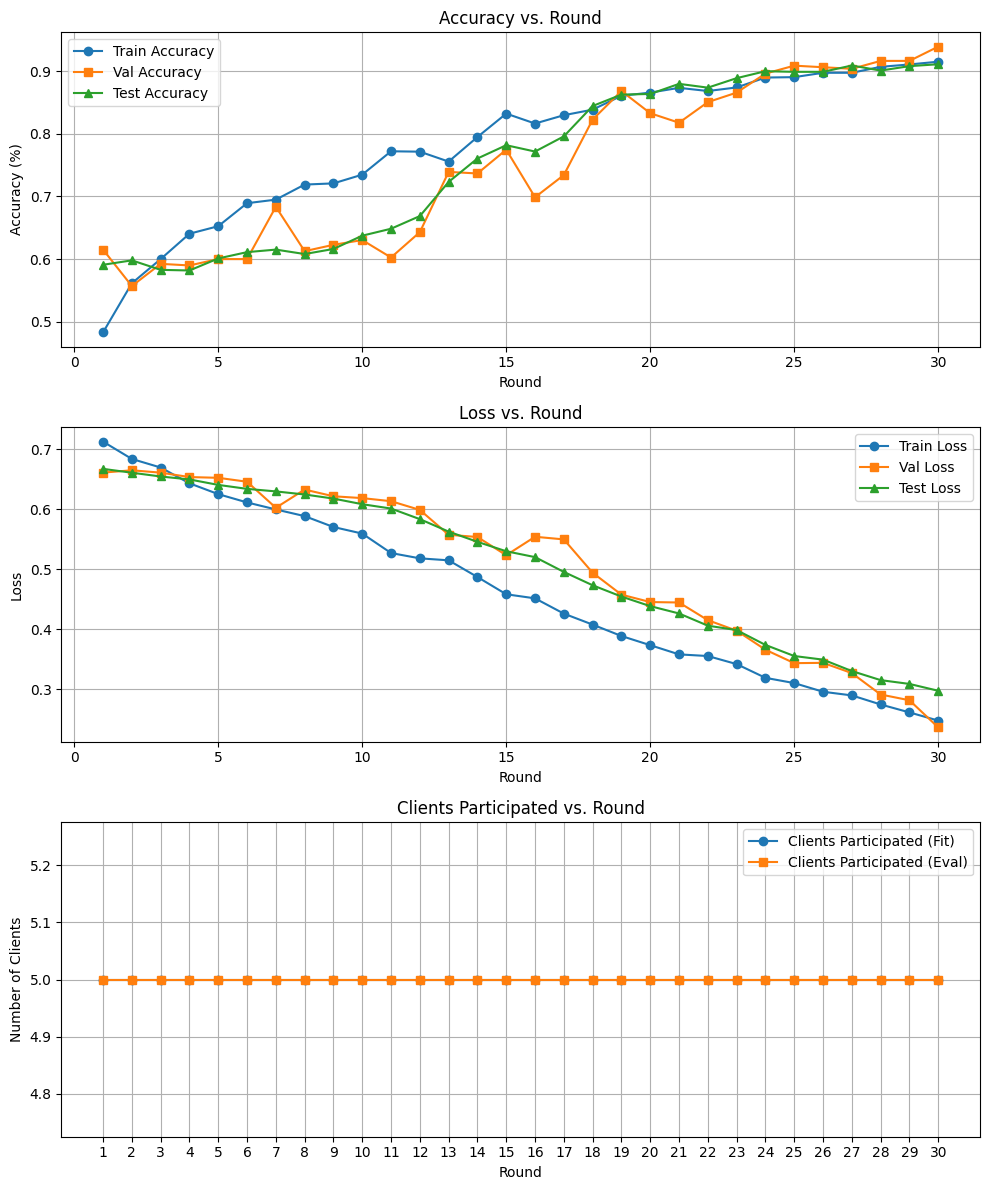

In [33]:
plt.figure(figsize=(10, 12))

# Biểu đồ Accuracy
plt.subplot(3, 1, 1)
plt.plot(range(1, len(HISTORY["train_accuracy"]) + 1), HISTORY["train_accuracy"], label="Train Accuracy", marker='o')
plt.plot(range(1, len(HISTORY["val_accuracy"]) + 1), HISTORY["val_accuracy"], label="Val Accuracy", marker='s')
plt.plot(range(1, len(HISTORY["test_accuracy"]) + 1), HISTORY["test_accuracy"], label="Test Accuracy", marker='^')
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Round")
plt.legend()
plt.grid(True)

# Biểu đồ Loss
plt.subplot(3, 1, 2)
plt.plot(range(1, len(HISTORY["train_loss"]) + 1), HISTORY["train_loss"], label="Train Loss", marker='o')
plt.plot(range(1, len(HISTORY["val_loss"]) + 1), HISTORY["val_loss"], label="Val Loss", marker='s')
plt.plot(range(1, len(HISTORY["test_loss"]) + 1), HISTORY["test_loss"], label="Test Loss", marker='^')
plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("Loss vs. Round")
plt.legend()
plt.grid(True)

# Biểu đồ Clients Participated
plt.subplot(3, 1, 3)
plt.plot(range(1, len(HISTORY["clients_participated_fit"]) + 1), HISTORY["clients_participated_fit"], label="Clients Participated (Fit)", marker='o')
plt.plot(range(1, len(HISTORY["clients_participated_eval"]) + 1), HISTORY["clients_participated_eval"], label="Clients Participated (Eval)", marker='s')
plt.xlabel("Round")
plt.ylabel("Number of Clients")
plt.title("Clients Participated vs. Round")
plt.legend()
plt.grid(True)
plt.xticks(range(1, max(len(HISTORY["clients_participated_fit"]), len(HISTORY["clients_participated_eval"])) + 1))

plt.tight_layout()